<a href="https://colab.research.google.com/github/syllerim/hyrox-performance-buddy/blob/main/1.Hyrox_ML/Hyrox_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# set up paths to dataset files stored in Google Drive
DATA_DIR = '/content/drive/MyDrive/KeepCoding/Bootcamp_AI/8.LLMs/Assignment/'

# original data
PATH_HYROX_DATA = f'{DATA_DIR}/hyrox_data_1.csv'
PATH_HYROX_DATA_INSTRUCTED = f'{DATA_DIR}/hyrox_data_instructed.csv'
PATH_HYROX_JSON_INSTRUCTED = f'{DATA_DIR}/hyrox_json_instructed.jsonl'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from lightgbm import LGBMRegressor

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# Exploration and Data Analysis (EDA)

In [ ]:
# load data
df_hyrox = pd.read_csv(PATH_HYROX_DATA, sep=',')

In [ ]:
# check the shape
df_hyrox.shape

(5260, 29)

In [ ]:
# show first five rows
df_hyrox.head(2)

,gender,age_group,total_time,work_strength_time,roxzone_time,work_run_time,run_1,1000m Ski,roxzone_1,run_2,50m Sled Push,roxzone_2,run_3,50m Sled Pull,roxzone_3,run_4,80m Burpee Broad Jump,roxzone_4,run_5,1000m Row,roxzone_5,run_6,200m Farmer Carry,roxzone_6,run_7,100m Sandbag Lunges,roxzone_7,run_8,100 Wall Balls
0,male,16-24,0:56:47,0:25:27,0:04:43,0:26:37,0:04:15,0:04:06,0:00:32,0:03:02,0:02:20,0:00:30,0:03:11,0:03:31,0:00:34,0:03:10,0:02:51,0:00:22,0:03:10,0:04:09,0:00:45,0:03:10,0:01:30,0:00:59,0:03:11,0:03:12,0:01:01,0:03:28,0:03:48
1,male,25-29,0:58:24,0:27:01,0:05:02,0:26:21,0:04:11,0:03:52,0:00:33,0:03:02,0:01:40,0:00:32,0:03:13,0:03:14,0:00:39,0:03:08,0:04:07,0:00:22,0:03:14,0:04:18,0:00:44,0:03:05,0:02:00,0:01:08,0:03:04,0:03:35,0:01:04,0:03:24,0:04:15


In [ ]:
df_hyrox.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5260 entries, 0 to 5259
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   gender                 5260 non-null   object
 1   age_group              5258 non-null   object
 2   total_time             5260 non-null   object
 3   work_strength_time     5260 non-null   object
 4   roxzone_time           5260 non-null   object
 5   work_run_time          5260 non-null   object
 6   run_1                  5260 non-null   object
 7   1000m Ski              5260 non-null   object
 8   roxzone_1              5260 non-null   object
 9   run_2                  5260 non-null   object
 10  50m Sled Push          5260 non-null   object
 11  roxzone_2              5260 non-null   object
 12  run_3                  5260 non-null   object
 13  50m Sled Pull          5260 non-null   object
 14  roxzone_3              5260 non-null   object
 15  run_4                

In [ ]:
# check the shape
df_hyrox.shape

(5260, 29)

In [ ]:
# apply binary encoding for gender column
df_hyrox['gender'] = df_hyrox['gender'].map({'male': 0, 'female': 1})

In [ ]:
# make sure the type of an instance is str
print(type(df_hyrox['total_time'].iloc[0]))


<class 'str'>


In [ ]:
# convertir mm:ss to secs
def time_to_seconds(time_str):
    """
    Convert a time string in format 'H:MM:SS' to total seconds.

    Args:
        time_str (str): Time string in format like '0:56:47'

    Returns:
        int: Total seconds

    Examples:
        >>> time_to_seconds('0:56:47')
        3407
        >>> time_to_seconds('1:30:15')
        5415
        >>> time_to_seconds('2:00:00')
        7200
    """
    try:
        # split the time string by ':'
        time_parts = time_str.split(':')

        if len(time_parts) != 3:
            raise ValueError("Time string must be in format 'H:MM:SS'")

        # vonvert each part to integer
        hours = int(time_parts[0])
        minutes = int(time_parts[1])
        seconds = int(time_parts[2])

        # validate ranges
        if minutes >= 60 or seconds >= 60:
            raise ValueError("Minutes and seconds must be less than 60")

        if hours < 0 or minutes < 0 or seconds < 0:
            raise ValueError("Time values cannot be negative")

        # convert to total seconds
        total_seconds = hours * 3600 + minutes * 60 + seconds

        return total_seconds

    except ValueError as e:
        if "invalid literal for int()" in str(e):
            raise ValueError("All time components must be valid integers") from e
        raise

In [ ]:
time_columns = [
    'total_time', 'work_strength_time', 'roxzone_time', 'work_run_time',
    'run_1', '1000m Ski', 'roxzone_1',
    'run_2', '50m Sled Push', 'roxzone_2',
    'run_3', '50m Sled Pull', 'roxzone_3',
    'run_4', '80m Burpee Broad Jump', 'roxzone_4',
    'run_5', '1000m Row', 'roxzone_5',
    'run_6', '200m Farmer Carry', 'roxzone_6',
    'run_7', '100m Sandbag Lunges', 'roxzone_7',
    'run_8', '100 Wall Balls'
]

for col in time_columns:
    df_hyrox[col] = df_hyrox[col].apply(time_to_seconds)

In [ ]:
df_hyrox.head(2)

,gender,age_group,total_time,work_strength_time,roxzone_time,work_run_time,run_1,1000m Ski,roxzone_1,run_2,50m Sled Push,roxzone_2,run_3,50m Sled Pull,roxzone_3,run_4,80m Burpee Broad Jump,roxzone_4,run_5,1000m Row,roxzone_5,run_6,200m Farmer Carry,roxzone_6,run_7,100m Sandbag Lunges,roxzone_7,run_8,100 Wall Balls
0,0,16-24,3407,1527,283,1597,255,246,32,182,140,30,191,211,34,190,171,22,190,249,45,190,90,59,191,192,61,208,228
1,0,25-29,3504,1621,302,1581,251,232,33,182,100,32,193,194,39,188,247,22,194,258,44,185,120,68,184,215,64,204,255


In [ ]:
# show distinct age_group for gender 0 and for gender 1

print("Distinct age groups for gender 0:")
print(df_hyrox[df_hyrox['gender'] == 0]['age_group'].unique())
print("\nDistinct age groups for gender 1:")
print(df_hyrox[df_hyrox['gender'] == 1]['age_group'].unique())

Distinct age groups for gender 0:
['16-24' '25-29' '35-39' '30-34' '40-44' '50-54' '45-49' '55-59' '60-64'
 '65-69' '16-29' '30-39' '40-49' '50-59' '60-69' '70-74']

Distinct age groups for gender 1:
['30-34' '25-29' '35-39' '16-24' '40-44' '45-49' '50-54' '55-59' '70-74'
 '65-69' nan '30-39' '40-49' '16-29' '50-59' '60-69' '60-64']


In [ ]:
# remove rows where NaN or na

df_hyrox = df_hyrox.dropna()
df_hyrox.shape
df_hyrox.isnull().sum()

,0
gender,0
age_group,0
total_time,0
work_strength_time,0
roxzone_time,0
work_run_time,0
run_1,0
1000m Ski,0
roxzone_1,0
run_2,0


In [ ]:
df_hyrox.shape

(5258, 29)

In [ ]:
# split age_group into age_min and age_max

df_hyrox[['age_min', 'age_max']] = df_hyrox['age_group'].str.split('-', expand=True).astype(int)
df_hyrox['age_span'] = (df_hyrox['age_max'] - df_hyrox['age_min']) + 1

In [ ]:
# column with age span
df_hyrox[['age_group', 'age_min', 'age_max', 'age_span']].head(5)

,age_group,age_min,age_max,age_span
0,16-24,16,24,9
1,25-29,25,29,5
2,35-39,35,39,5
3,30-34,30,34,5
4,30-34,30,34,5


In [ ]:
# normalize per station to build a performance profile per athlete across all stations

stations = [
    '1000m Ski',
    '50m Sled Push',
    '50m Sled Pull',
    '80m Burpee Broad Jump',
    '1000m Row',
    '200m Farmer Carry',
    '100m Sandbag Lunges',
    '100 Wall Balls',
    'work_run_time',
    'roxzone_time',
]

In [ ]:
# Z-score normalization (standardization)
# comparing how far one user is from the average (residual analysis)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_zscore = pd.DataFrame(scaler.fit_transform(df_hyrox[stations]), columns=stations)

# add normalized profile back to dataset
for col in stations:
    df_hyrox[f'{col}_zscore'] = df_zscore[col]

In [ ]:
# Min-Max scaling
# what does your profile 'look like'

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_minmax = pd.DataFrame(scaler.fit_transform(df_hyrox[stations]), columns=stations)

# add normalized profile back to df
for col in stations:
    df_hyrox[f'{col}_minmax'] = df_minmax[col]

In [ ]:
df_hyrox.head(2)

,gender,age_group,total_time,work_strength_time,roxzone_time,work_run_time,run_1,1000m Ski,roxzone_1,run_2,50m Sled Push,roxzone_2,run_3,50m Sled Pull,roxzone_3,run_4,80m Burpee Broad Jump,roxzone_4,run_5,1000m Row,roxzone_5,run_6,200m Farmer Carry,roxzone_6,run_7,100m Sandbag Lunges,roxzone_7,run_8,100 Wall Balls,age_min,age_max,age_span,1000m Ski_zscore,50m Sled Push_zscore,50m Sled Pull_zscore,80m Burpee Broad Jump_zscore,1000m Row_zscore,200m Farmer Carry_zscore,100m Sandbag Lunges_zscore,100 Wall Balls_zscore,work_run_time_zscore,roxzone_time_zscore,1000m Ski_minmax,50m Sled Push_minmax,50m Sled Pull_minmax,80m Burpee Broad Jump_minmax,1000m Row_minmax,200m Farmer Carry_minmax,100m Sandbag Lunges_minmax,100 Wall Balls_minmax,work_run_time_minmax,roxzone_time_minmax
0,0,16-24,3407,1527,283,1597,255,246,32,182,140,30,191,211,34,190,171,22,190,249,45,190,90,59,191,192,61,208,228,16,24,9,-1.018084,-0.547182,-1.026214,-1.211533,-1.573979,-1.169684,-1.068900,-1.022785,-2.223910,-1.263085,0.479564,0.216383,0.181116,0.083374,0.110714,0.195228,0.128686,0.135227,0.007373,0.080039
1,0,25-29,3504,1621,302,1581,251,232,33,182,100,32,193,194,39,188,247,22,194,258,44,185,120,68,184,215,64,204,255,25,29,5,-1.481417,-1.338699,-1.199426,-0.673290,-1.299160,-0.320389,-0.850981,-0.839685,-2.258048,-1.108390,0.441417,0.154560,0.166524,0.120429,0.142857,0.260304,0.144102,0.153482,0.004269,0.098361


**Correlation heatmap**

Check if some stations are strongly correlated (e.g., Row ↔ SkiErg)

Helps decide if PCA or feature reduction is worth trying

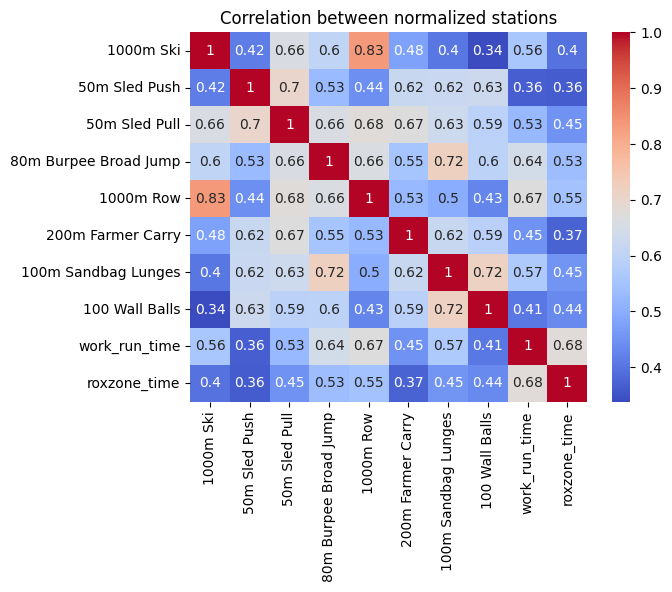

<Figure size 5000x5000 with 0 Axes>

In [ ]:
sns.heatmap(df_zscore.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation between normalized stations")
plt.figure(figsize=(50, 50))
plt.show()

**Pairplot / scatter matrix**

Visualize athlete spread between key stations (2D)

Good for seeing natural clusters

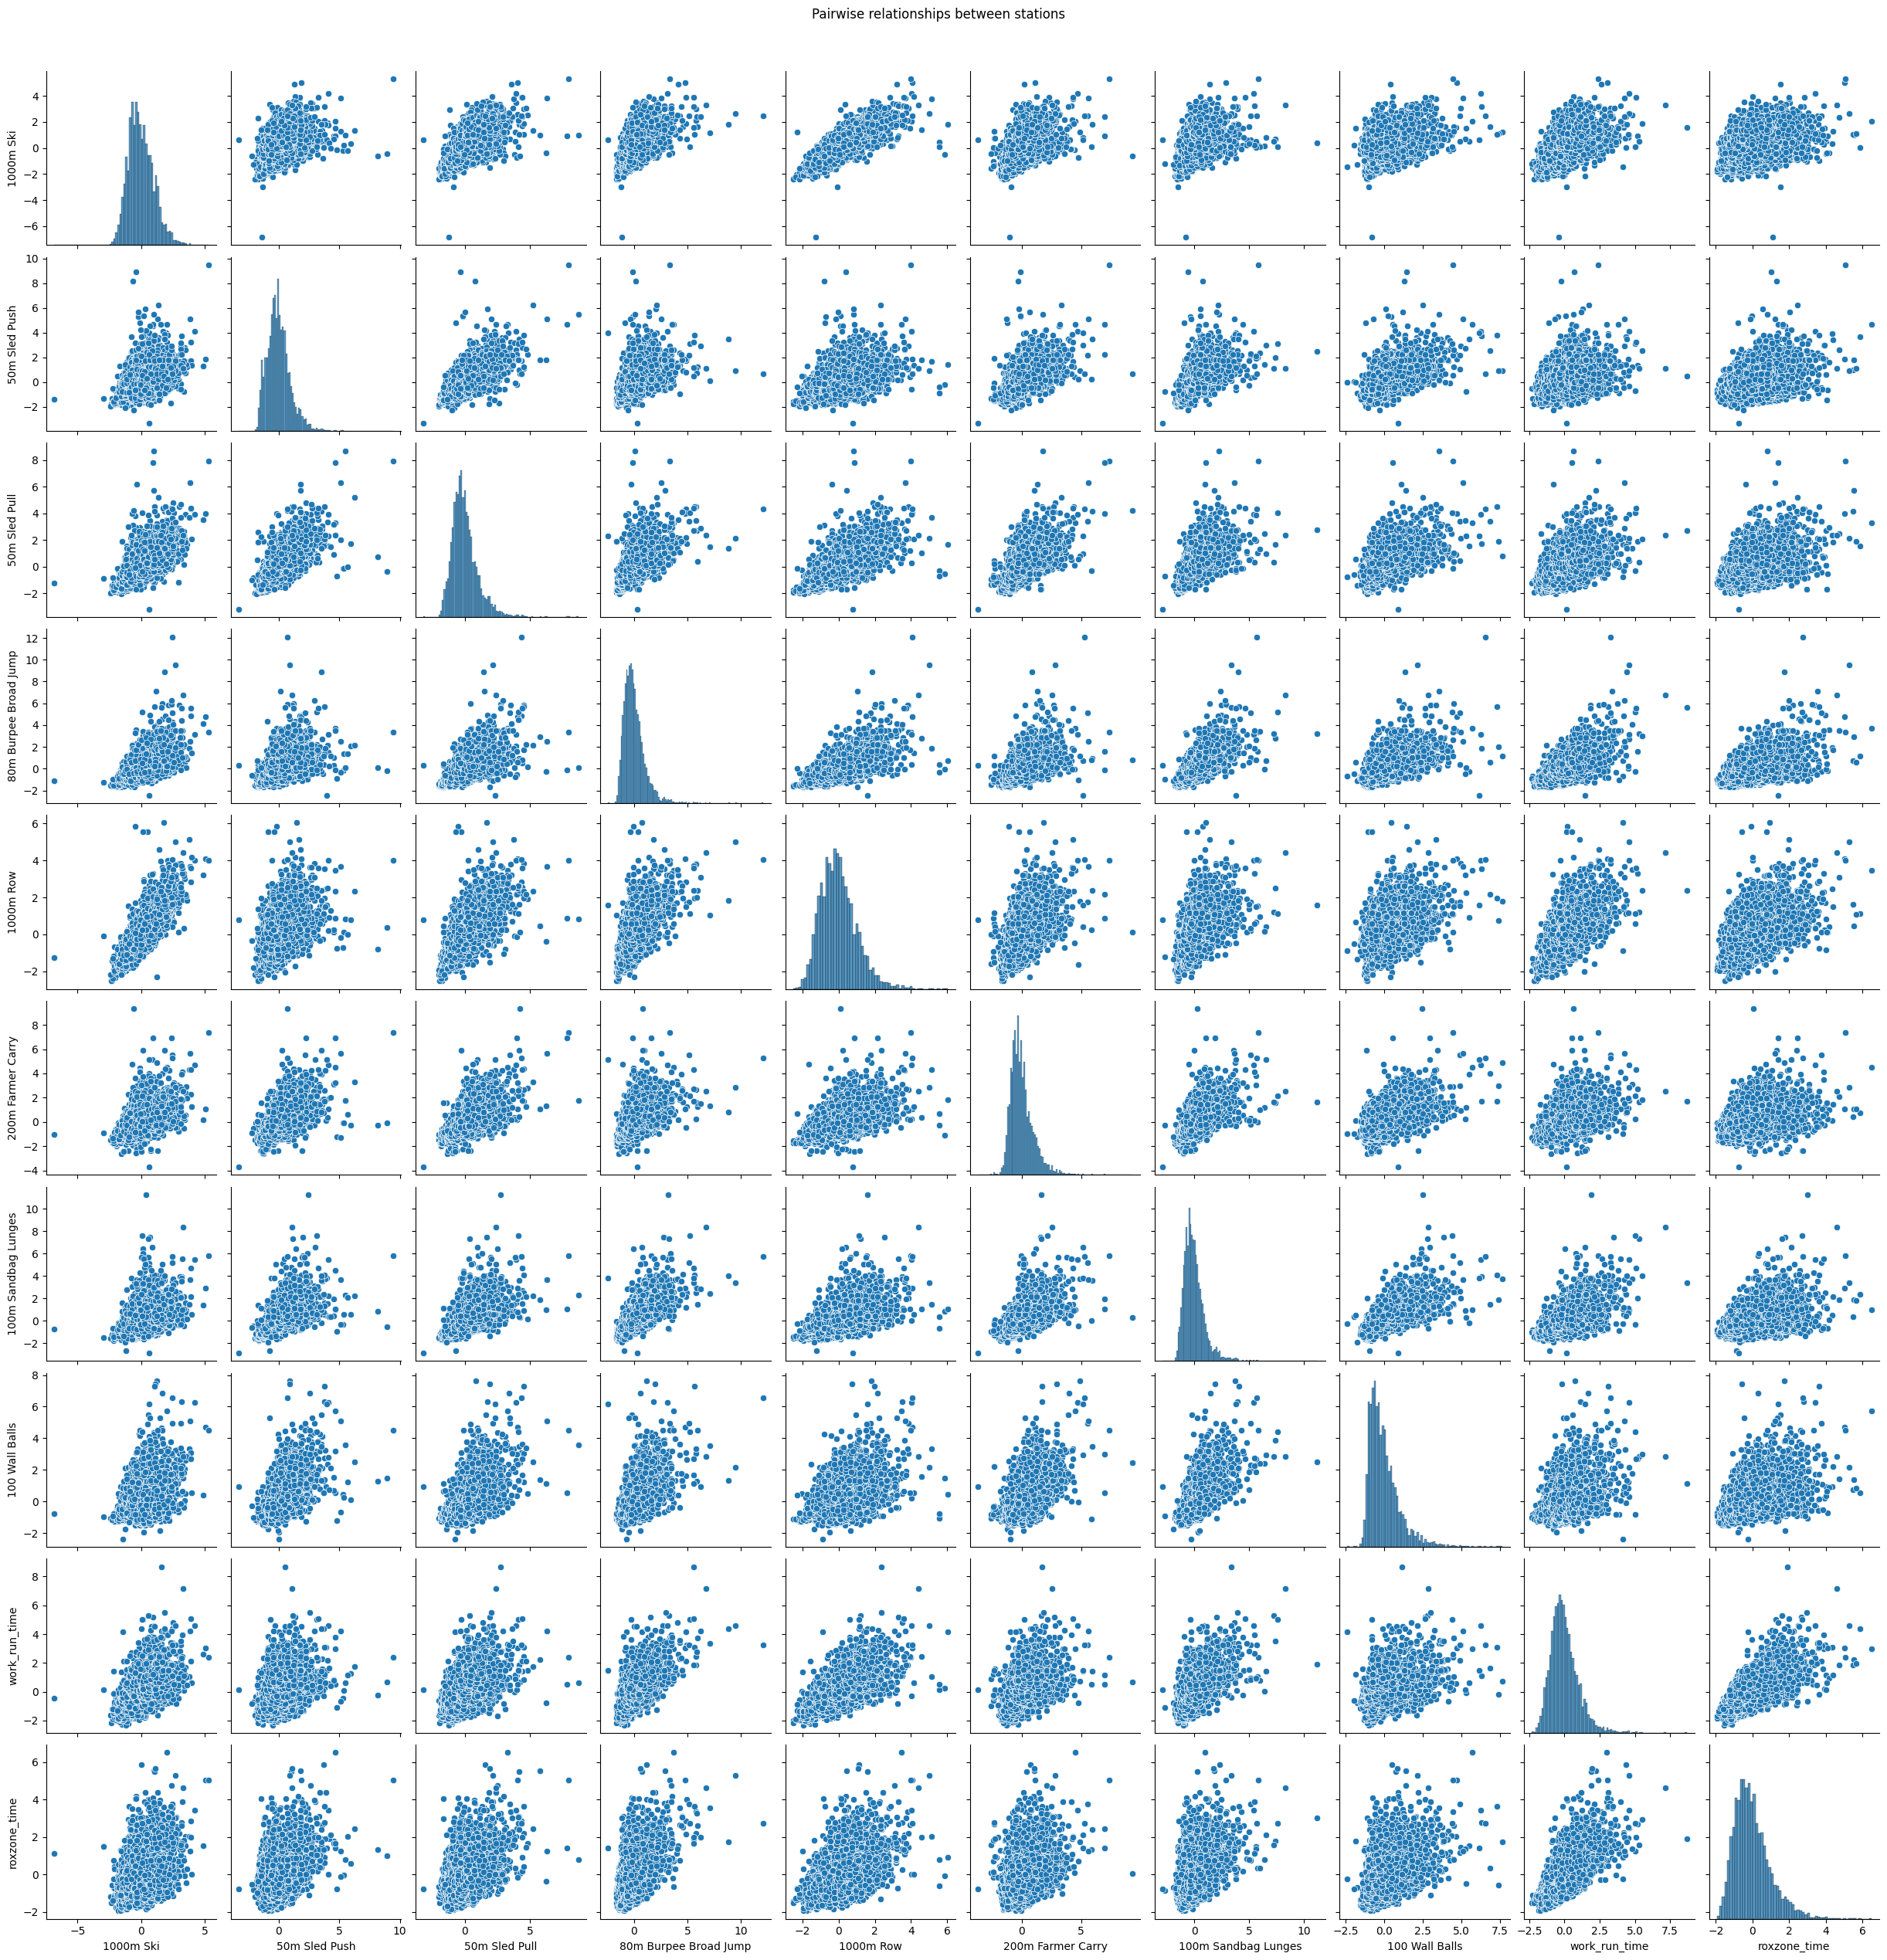

In [ ]:
sns.pairplot(df_zscore)
plt.suptitle("Pairwise relationships between stations", y=1.02)
plt.show()

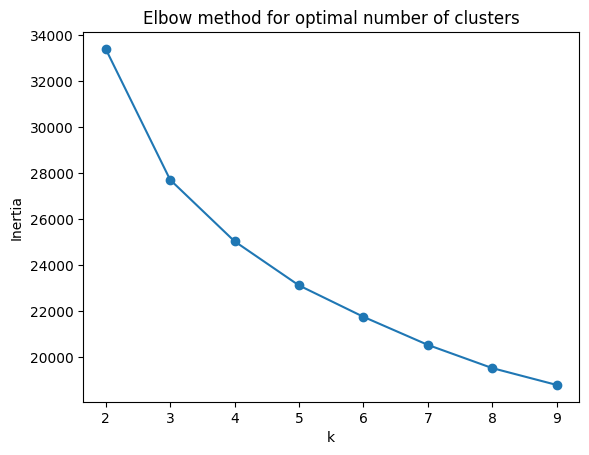

In [ ]:
inertias = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42).fit(df_zscore)
    inertias.append(km.inertia_)

plt.plot(range(2, 10), inertias, marker='o')
plt.title('Elbow method for optimal number of clusters')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()


In [ ]:
# the best optimal k is between 4 - 5, that means that adding more clusters won't help

## Clustering Similar Athletes

In [ ]:
# stations minmax for clustering
stations_cols_minmax = [f'{col}_minmax' for col in stations]

In [ ]:
# add personal context
personal_context_cols = ['gender', 'age_min', 'age_max']

# Combine all features
feature_cols = stations_cols_minmax + personal_context_cols

In [ ]:
# drop nulls from df_hyrox

df_hyrox = df_hyrox.dropna()

In [ ]:
# drop nulls for clustering
X = df_hyrox[feature_cols].dropna()

In [ ]:
# Apply MinMaxScaler to scale everything to [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=X.index)

In [ ]:
X_scaled_df.head(2)

,1000m Ski_minmax,50m Sled Push_minmax,50m Sled Pull_minmax,80m Burpee Broad Jump_minmax,1000m Row_minmax,200m Farmer Carry_minmax,100m Sandbag Lunges_minmax,100 Wall Balls_minmax,work_run_time_minmax,roxzone_time_minmax,gender,age_min,age_max
0,0.479564,0.216383,0.181116,0.083374,0.110714,0.195228,0.128686,0.135227,0.007373,0.080039,0.0,0.000000,0.0
1,0.441417,0.154560,0.166524,0.120429,0.142857,0.260304,0.144102,0.153482,0.004269,0.098361,0.0,0.166667,0.1


In [ ]:
# pick k=5 based on the elbow plot

kmeans = KMeans(n_clusters=6, random_state=42)
X['cluster'] = kmeans.fit_predict(X_scaled)
df_hyrox.loc[X.index, 'cluster'] = X['cluster']

<ipython-input-36-497a6b94573e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hyrox.loc[X.index, 'cluster'] = X['cluster']


In [ ]:
# save the scaler for inverse transform
X_original = scaler.inverse_transform(X_scaled)

In [ ]:
# to answer things like: What are the typical strengths/weaknesses of each group?
# average profile of each cluster, which is the key to understanding what kind of athletes are in each group.
cluster_profiles = df_hyrox.groupby('cluster')[stations_cols_minmax + ['gender', 'age_min', 'age_max', ]].mean()

In [ ]:
cluster_profiles

,1000m Ski_minmax,50m Sled Push_minmax,50m Sled Pull_minmax,80m Burpee Broad Jump_minmax,1000m Row_minmax,200m Farmer Carry_minmax,100m Sandbag Lunges_minmax,100 Wall Balls_minmax,work_run_time_minmax,roxzone_time_minmax,gender,age_min,age_max
cluster,,,,,,,,,,,,,
0.0,0.594714,0.219138,0.248443,0.150241,0.319968,0.260163,0.166077,0.172615,0.204936,0.210111,1.0,26.246305,32.995074
1.0,0.579935,0.351787,0.347709,0.222295,0.360931,0.366528,0.295413,0.380637,0.281307,0.348020,0.0,33.478041,37.758446
2.0,0.631914,0.248946,0.286894,0.182601,0.371146,0.286659,0.194744,0.203070,0.242916,0.241707,1.0,43.601695,48.618644
3.0,0.522366,0.264532,0.252051,0.155412,0.247268,0.278954,0.209649,0.252782,0.191656,0.212649,0.0,44.493414,49.141844
4.0,0.494785,0.233610,0.218622,0.128728,0.197760,0.252931,0.178825,0.209530,0.149942,0.163971,0.0,28.159533,33.714656
5.0,0.699611,0.324376,0.386289,0.270083,0.483590,0.358749,0.266590,0.315478,0.327137,0.373232,1.0,30.475728,35.298544


### Clusters Women

In [ ]:
# Analyze cluster profiles specifically for gender 1
gender_1_profiles = cluster_profiles[cluster_profiles['gender'].round() == 1]

# for each cluster, sort the stations from best to worst
cluster_gender_1_rankings = {}

for cluster_id, row in gender_1_profiles.iterrows():
    sorted_stations = row.sort_values(ascending=False)
    cluster_gender_1_rankings[cluster_id] = sorted_stations

for cluster_id, ranking in cluster_gender_1_rankings.items():
    print(f"\n✳️ Cluster {cluster_id} ranking:")
    print(ranking.to_string())


✳️ Cluster 0.0 ranking:
age_max                         32.995074
age_min                         26.246305
gender                           1.000000
1000m Ski_minmax                 0.594714
1000m Row_minmax                 0.319968
200m Farmer Carry_minmax         0.260163
50m Sled Pull_minmax             0.248443
50m Sled Push_minmax             0.219138
roxzone_time_minmax              0.210111
work_run_time_minmax             0.204936
100 Wall Balls_minmax            0.172615
100m Sandbag Lunges_minmax       0.166077
80m Burpee Broad Jump_minmax     0.150241

✳️ Cluster 2.0 ranking:
age_max                         48.618644
age_min                         43.601695
gender                           1.000000
1000m Ski_minmax                 0.631914
1000m Row_minmax                 0.371146
50m Sled Pull_minmax             0.286894
200m Farmer Carry_minmax         0.286659
50m Sled Push_minmax             0.248946
work_run_time_minmax             0.242916
roxzone_time_minmax       

### Clusters Men

In [ ]:
gender_0_profiles = cluster_profiles[cluster_profiles['gender'].round() == 0]
cluster_gender_0_rankings = {}

for cluster_id, row in gender_0_profiles.iterrows():
    sorted_stations = row.sort_values(ascending=False)
    cluster_gender_0_rankings[cluster_id] = sorted_stations

for cluster_id, ranking in cluster_gender_0_rankings.items():
    print(f"\n✳️ Cluster {cluster_id} ranking:")
    print(ranking.to_string())


✳️ Cluster 1.0 ranking:
age_max                         37.758446
age_min                         33.478041
1000m Ski_minmax                 0.579935
100 Wall Balls_minmax            0.380637
200m Farmer Carry_minmax         0.366528
1000m Row_minmax                 0.360931
50m Sled Push_minmax             0.351787
roxzone_time_minmax              0.348020
50m Sled Pull_minmax             0.347709
100m Sandbag Lunges_minmax       0.295413
work_run_time_minmax             0.281307
80m Burpee Broad Jump_minmax     0.222295
gender                           0.000000

✳️ Cluster 3.0 ranking:
age_max                         49.141844
age_min                         44.493414
1000m Ski_minmax                 0.522366
200m Farmer Carry_minmax         0.278954
50m Sled Push_minmax             0.264532
100 Wall Balls_minmax            0.252782
50m Sled Pull_minmax             0.252051
1000m Row_minmax                 0.247268
roxzone_time_minmax              0.212649
100m Sandbag Lunges_minmax

**How to understand this?**

Each row is a cluster (group of similar athlets).
Each column represents the normalized average of a station or personal variable.

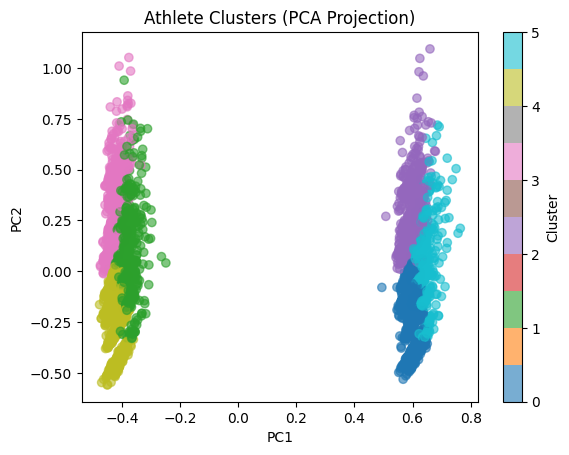

In [ ]:
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

plt.scatter(components[:, 0], components[:, 1], c=X['cluster'], cmap='tab10', alpha=0.6)
plt.title("Athlete Clusters (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

## Feature Importance - Predict total time

The analysis of feature importance allows me to combine it with the clustering strategy, so that I can undertand, not only where a person has worst performance, but also how it impact the total time.

The approach is to train both a LinearRegression and a LightGBM and use the best model predictions to compute residuals.

In [ ]:
# reuse X_scaled_df which is ready-to-train feature set
X_final = X_scaled_df
y_final = df_hyrox['total_time']

In [ ]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

### Linear Regression

In [ ]:
# train the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# eval the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
mins = np.sqrt(mse)
print(f'RMSE: {mse}')
print(f'Mins: {mins/60}')

RMSE: 23998.11351916579
Mins: 2.5818874189655747


The model predicts with a total average error of mins for races that takes in total around 1 hour.

### LightGBM


In [ ]:
lightgbmModel = LGBMRegressor()
lightgbmModel.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 4204, number of used features: 13
[LightGBM] [Info] Start training from score 5290.653425


LGBMRegressor()

In [ ]:
preds = lightgbmModel.predict(X_test)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse / 60:.2f} minutes")  # Convert to minutes

RMSE: 2.91 minutes


## Compute residuals


In [ ]:
# make sure to get the correct columns
features = X_final.columns.tolist()

# fet predictions for all athletes
df_hyrox['predicted_total_time'] = model.predict(df_hyrox[features])

# calculate residuals
df_hyrox['residual'] = df_hyrox['total_time'] - df_hyrox['predicted_total_time']

<ipython-input-49-f6041ddd15f2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hyrox['predicted_total_time'] = model.predict(df_hyrox[features])
<ipython-input-49-f6041ddd15f2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hyrox['residual'] = df_hyrox['total_time'] - df_hyrox['predicted_total_time']


**Residual Value → Interpretation**

positive → 🟥 Slower than expected → underperformed

negative → 🟩 Faster than expected → outperformed

≈ 0 → 🟨 Performed close to prediction


In [ ]:
df_hyrox[['gender', 'age_min', 'age_max', 'age_span', 'total_time', 'predicted_total_time', 'residual']].head(5)

,gender,age_min,age_max,age_span,total_time,predicted_total_time,residual
0,0,16,24,9,3407,3010.034086,396.965914
1,0,25,29,5,3504,3679.448829,-175.448829
2,0,35,39,5,3633,4026.278917,-393.278917
3,0,30,34,5,3716,3998.344489,-282.344489
4,0,30,34,5,3730,4012.811058,-282.811058


In [ ]:
# compare to cluster average per station
def get_station_gaps_vs_cluster(row, cluster_profiles, threshold=0.05):
    cluster_avg = cluster_profiles.loc[row['cluster']]
    underperforming = []
    for col in stations_cols_minmax:
        if row[col] < cluster_avg[col] - threshold:
            underperforming.append(col.replace('_minmax', ''))
    return underperforming

In [ ]:
# merge everything into one interpretation
def interpret_athlete(row, cluster_profiles):
    res = row['residual']
    cluster_id = row['cluster']
    cluster_gaps = get_station_gaps_vs_cluster(row, cluster_profiles)

    if res > 180:
        base = "You performed slower than expected by more than 3 minutes."
    elif res < -180:
        base = "You outperformed the model’s prediction significantly — great job!"
    else:
        base = "You performed close to expected levels."

    if cluster_gaps:
        return f"{base} Compared to your cluster (#{cluster_id}), you may want to improve: {', '.join(cluster_gaps)}."
    else:
        return f"{base} You are performing in line with your cluster’s average strengths."

df_hyrox['performance_feedback'] = df_hyrox.apply(lambda row: interpret_athlete(row, cluster_profiles), axis=1)

<ipython-input-52-938824d645d7>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hyrox['performance_feedback'] = df_hyrox.apply(lambda row: interpret_athlete(row, cluster_profiles), axis=1)


In [ ]:
df_hyrox[[
    'gender', 'age_min', 'age_max', 'total_time',
    'predicted_total_time', 'residual', 'performance_feedback'
]].head(5)

,gender,age_min,age_max,total_time,predicted_total_time,residual,performance_feedback
0,0,16,24,3407,3010.034086,396.965914,"You performed slower than expected by more than 3 minutes. Compared to your cluster (#4.0), you may want to improve: 1000m Row, 200m Farmer Carry, 100m Sandbag Lunges, 100 Wall Balls, work_run_time, roxzone_time."
1,0,25,29,3504,3679.448829,-175.448829,"You performed close to expected levels. Compared to your cluster (#4.0), you may want to improve: 1000m Ski, 50m Sled Push, 50m Sled Pull, 1000m Row, 100 Wall Balls, work_run_time, roxzone_time."
2,0,35,39,3633,4026.278917,-393.278917,"You outperformed the model’s prediction significantly — great job! Compared to your cluster (#4.0), you may want to improve: 1000m Row, 200m Farmer Carry, 100m Sandbag Lunges, 100 Wall Balls, work_run_time, roxzone_time."
3,0,30,34,3716,3998.344489,-282.344489,"You outperformed the model’s prediction significantly — great job! Compared to your cluster (#4.0), you may want to improve: 50m Sled Pull, 1000m Row, 100 Wall Balls, work_run_time, roxzone_time."
4,0,30,34,3730,4012.811058,-282.811058,"You outperformed the model’s prediction significantly — great job! Compared to your cluster (#4.0), you may want to improve: 50m Sled Pull, 1000m Row, 200m Farmer Carry, work_run_time, roxzone_time."


# Preparate Dataset for Instruction-tuning

In [ ]:
def add_instruction_tuning_columns(df):
    def extract_cluster(feedback):
        match = re.search(r'#(\d+)', feedback)
        return int(match.group(1)) if match else None

    def format_input(row):
        cluster = extract_cluster(row['performance_feedback'])
        return f"gender: {row['gender']}, age: {row['age_min']}-{row['age_max']}, total_time: {int(row['total_time'])}, predicted: {int(round(row['predicted_total_time']))}, residual: {int(round(row['residual']))}, cluster: {cluster}"

    df["input"] = "Generate performance feedback based on prediction and true time"
    df["context"] = df.apply(format_input, axis=1)
    df["response"] = df["performance_feedback"]

    return df

In [ ]:
df_hyrox = add_instruction_tuning_columns(df_hyrox)

In [ ]:
df_hyrox[[
    'gender', 'age_min', 'age_max', 'total_time',
    'predicted_total_time', 'residual', 'performance_feedback',
    'input', 'context', 'response'
]].head(5)

,gender,age_min,age_max,total_time,predicted_total_time,residual,performance_feedback,input,context,response
0,0,16,24,3407,3010.034086,396.965914,"You performed slower than expected by more than 3 minutes. Compared to your cluster (#4.0), you may want to improve: 1000m Row, 200m Farmer Carry, 100m Sandbag Lunges, 100 Wall Balls, work_run_time, roxzone_time.",Generate performance feedback based on prediction and true time,"gender: 0, age: 16-24, total_time: 3407, predicted: 3010, residual: 397, cluster: 4","You performed slower than expected by more than 3 minutes. Compared to your cluster (#4.0), you may want to improve: 1000m Row, 200m Farmer Carry, 100m Sandbag Lunges, 100 Wall Balls, work_run_time, roxzone_time."
1,0,25,29,3504,3679.448829,-175.448829,"You performed close to expected levels. Compared to your cluster (#4.0), you may want to improve: 1000m Ski, 50m Sled Push, 50m Sled Pull, 1000m Row, 100 Wall Balls, work_run_time, roxzone_time.",Generate performance feedback based on prediction and true time,"gender: 0, age: 25-29, total_time: 3504, predicted: 3679, residual: -175, cluster: 4","You performed close to expected levels. Compared to your cluster (#4.0), you may want to improve: 1000m Ski, 50m Sled Push, 50m Sled Pull, 1000m Row, 100 Wall Balls, work_run_time, roxzone_time."
2,0,35,39,3633,4026.278917,-393.278917,"You outperformed the model’s prediction significantly — great job! Compared to your cluster (#4.0), you may want to improve: 1000m Row, 200m Farmer Carry, 100m Sandbag Lunges, 100 Wall Balls, work_run_time, roxzone_time.",Generate performance feedback based on prediction and true time,"gender: 0, age: 35-39, total_time: 3633, predicted: 4026, residual: -393, cluster: 4","You outperformed the model’s prediction significantly — great job! Compared to your cluster (#4.0), you may want to improve: 1000m Row, 200m Farmer Carry, 100m Sandbag Lunges, 100 Wall Balls, work_run_time, roxzone_time."
3,0,30,34,3716,3998.344489,-282.344489,"You outperformed the model’s prediction significantly — great job! Compared to your cluster (#4.0), you may want to improve: 50m Sled Pull, 1000m Row, 100 Wall Balls, work_run_time, roxzone_time.",Generate performance feedback based on prediction and true time,"gender: 0, age: 30-34, total_time: 3716, predicted: 3998, residual: -282, cluster: 4","You outperformed the model’s prediction significantly — great job! Compared to your cluster (#4.0), you may want to improve: 50m Sled Pull, 1000m Row, 100 Wall Balls, work_run_time, roxzone_time."
4,0,30,34,3730,4012.811058,-282.811058,"You outperformed the model’s prediction significantly — great job! Compared to your cluster (#4.0), you may want to improve: 50m Sled Pull, 1000m Row, 200m Farmer Carry, work_run_time, roxzone_time.",Generate performance feedback based on prediction and true time,"gender: 0, age: 30-34, total_time: 3730, predicted: 4013, residual: -283, cluster: 4","You outperformed the model’s prediction significantly — great job! Compared to your cluster (#4.0), you may want to improve: 50m Sled Pull, 1000m Row, 200m Farmer Carry, work_run_time, roxzone_time."


In [ ]:
# save dataset as csv for easy review
df_hyrox.to_csv(PATH_HYROX_DATA_INSTRUCTED, sep=',', index=False)

In [ ]:
# save it also in format better for LLM fine-tuning
df_hyrox[["input", "context", "response"]].to_json(PATH_HYROX_JSON_INSTRUCTED, orient="records", lines=True)